# KAN Mixture Density Network

**This notebook is intended to introduce a Kolmogorov-Arnold Network into a classical Mixture Density Network** <br>
**by using `efficient-kan` library and PyTorch**

In [15]:
import efficient_kan
from efficient_kan import KAN, KANLinear
import torch

from torch import nn
from torch import optim
from torch.functional import F
from torch.distributions import Categorical, MixtureSameFamily, MultivariateNormal

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from chebykanlayer import ChebyKANLayer
from fourierkanlayer import NaiveFourierKANLayer
from helper_functions import *

In [3]:
def create_mdn_distribution(pi, mu, sigma):
    """
    Create a MixtureSameFamily distribution from MDN outputs.
    
    Args:
    - pi: tensor of shape [batch_size, num_mixtures] - mixture weights
    - mu: tensor of shape [batch_size, num_mixtures, output_dim] - means
    - sigma: tensor of shape [batch_size, num_mixtures, output_dim] - standard deviations
    
    Returns:
    - mdn_dist: a MixtureSameFamily distribution
    """
    # Create the Categorical distribution for mixture components
    mix = Categorical(probs=pi)
    
    # Create the MultivariateNormal distribution for each component
    comp = MultivariateNormal(loc=mu, scale_tril=torch.diag_embed(sigma))
    
    # Combine into a mixture distribution
    mdn_dist = MixtureSameFamily(mix, comp)
    
    return mdn_dist

def sample_from_mdn(pi, mu, sigma, num_samples=1):
    """
    Sample from a Mixture Density Network output using MixtureSameFamily.
    
    Args:
    - pi: tensor of shape [batch_size, num_mixtures] - mixture weights
    - mu: tensor of shape [batch_size, num_mixtures, output_dim] - means
    - sigma: tensor of shape [batch_size, num_mixtures, output_dim] - standard deviations
    - num_samples: number of samples to draw for each input
    
    Returns:
    - samples: tensor of shape [batch_size, num_samples, output_dim]
    """
    mdn_dist = create_mdn_distribution(pi, mu, sigma)
    return mdn_dist.sample((num_samples,)).transpose(0, 1)


In [4]:
class mixdensnet(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_mixtures):
        super().__init__()
        
        self.hidden_block = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.pi = nn.Linear(hidden_dim, n_mixtures)
        self.mu = nn.Linear(hidden_dim, n_mixtures)
        self.sigma = nn.Linear(hidden_dim, n_mixtures)
        
    def forward(self, x):
        # x = self.block(x)
        hidden = self.hidden_block(x)
        # Separate the output into mixture components
        pi, mu, sigma = F.softmax(self.pi(hidden), 1), self.mu(hidden), torch.exp(self.sigma(hidden))
        
        return pi, mu, sigma
    

class MixtureDensityNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_mixtures, n_hidden_layers=2):
        super().__init__()

        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for _ in range(n_hidden_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
        self.hidden_block = nn.Sequential(*layers)

        # Output layers
        self.pi = nn.Linear(hidden_dim, n_mixtures)
        self.mu = nn.Linear(hidden_dim, n_mixtures * output_dim)
        self.sigma = nn.Linear(hidden_dim, n_mixtures * output_dim)
        
        self.n_mixtures = n_mixtures
        self.output_dim = output_dim

    def forward(self, x):
        hidden = self.hidden_block(x)
        
        pi = F.softmax(self.pi(hidden), dim=1)
        mu = self.mu(hidden)
        sigma = torch.exp(self.sigma(hidden))
        
        if self.output_dim > 1:
            mu = mu.view(-1, self.n_mixtures, self.output_dim)
            sigma = sigma.view(-1, self.n_mixtures, self.output_dim)
        
        return pi, mu, sigma

In [5]:
class KANMixtureDensityNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_mixtures):
        super().__init__()


        self.hidden_block = nn.Sequential(
            KANLinear(input_dim, hidden_dim),
            nn.ReLU(),
            KANLinear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.pi = KANLinear(hidden_dim, n_mixtures)
        self.mu = KANLinear(hidden_dim, n_mixtures)
        self.sigma = KANLinear(hidden_dim, n_mixtures)

    
    def forward(self, x):

        hidden = self.hidden_block(x)

        pi, mu, sigma = F.softmax(self.pi(hidden), 1), self.mu(hidden), torch.exp(self.sigma(hidden))

        return pi, mu, sigma
    
class MultivariateKANMixtureDensityNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_mixtures, n_hidden_layers=2):
        super().__init__()

        layers = [KANLinear(input_dim, hidden_dim), nn.ReLU()]
        for _ in range(n_hidden_layers - 1):
            layers.extend([KANLinear(hidden_dim, hidden_dim), nn.ReLU()])
        self.hidden_block = nn.Sequential(*layers)

        # Output layers
        self.pi = KANLinear(hidden_dim, n_mixtures)
        self.mu = KANLinear(hidden_dim, n_mixtures * output_dim)
        self.sigma = KANLinear(hidden_dim, n_mixtures * output_dim)
        
        self.n_mixtures = n_mixtures
        self.output_dim = output_dim

    def forward(self, x):
        hidden = self.hidden_block(x)
        
        pi = F.softmax(self.pi(hidden), dim=1)
        mu = self.mu(hidden)
        sigma = torch.exp(self.sigma(hidden))
        
        if self.output_dim > 1:
            mu = mu.view(-1, self.n_mixtures, self.output_dim)
            sigma = sigma.view(-1, self.n_mixtures, self.output_dim)
        
        return pi, mu, sigma




In [6]:
class ChebyKANMixtureDensityNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_mixtures, degree):
        super().__init__()


        self.hidden_block = nn.Sequential(
            ChebyKANLayer(input_dim, hidden_dim, degree=degree),
            nn.ReLU(),
            ChebyKANLayer(hidden_dim, hidden_dim, degree=degree),
            nn.ReLU()
        )

        self.pi = ChebyKANLayer(hidden_dim, n_mixtures, degree=degree)
        self.mu = ChebyKANLayer(hidden_dim, n_mixtures, degree=degree)
        self.sigma = ChebyKANLayer(hidden_dim, n_mixtures, degree=degree)

    
    def forward(self, x):

        hidden = self.hidden_block(x)

        pi, mu, sigma = F.softmax(self.pi(hidden), 1), self.mu(hidden), torch.exp(self.sigma(hidden))

        return pi, mu, sigma


In [7]:
class FourierKANMixtureDensityNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_mixtures, gridsize, smooth_init=False):
        super().__init__()


        self.hidden_block = nn.Sequential(
            NaiveFourierKANLayer(input_dim, hidden_dim, gridsize, smooth_init),
            nn.ReLU(),
            NaiveFourierKANLayer(hidden_dim, hidden_dim, gridsize, smooth_init),
            nn.ReLU()
        )

        self.pi = NaiveFourierKANLayer(hidden_dim, n_mixtures, gridsize, smooth_init)
        self.mu = NaiveFourierKANLayer(hidden_dim, n_mixtures, gridsize, smooth_init)
        self.sigma = NaiveFourierKANLayer(hidden_dim, n_mixtures, gridsize, smooth_init)

    
    def forward(self, x):

        hidden = self.hidden_block(x)

        pi, mu, sigma = F.softmax(self.pi(hidden), 1), self.mu(hidden), torch.exp(self.sigma(hidden))

        return pi, mu, sigma


In [8]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

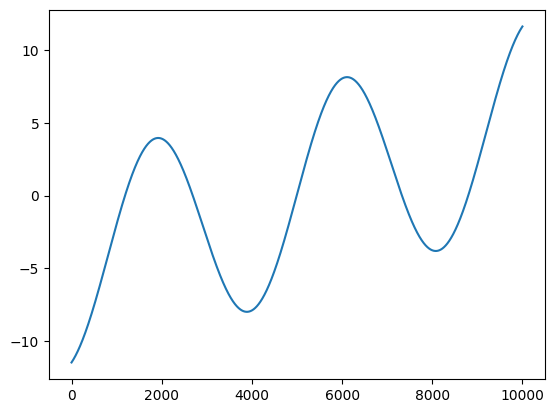

In [9]:
x_train, y_train = generate_samples(10000)
plt.plot(y_train.cpu().numpy())

In [12]:
# Define the MDN
mdn = MixtureDensityNetwork(input_dim=1, output_dim=1, hidden_dim=30, n_mixtures=3, n_hidden_layers=2).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(params=mdn.parameters(), 
                             lr=0.001)


In [13]:
pi, mu, sigma = training_process(mdn, mdn_loss, optimizer, 3000, x_train, y_train)

Epoch: 0 | Loss: 15.09264
Epoch: 100 | Loss: 3.55754
Epoch: 200 | Loss: 3.13337
Epoch: 300 | Loss: 2.88402
Epoch: 400 | Loss: 2.74902
Epoch: 500 | Loss: 2.51710
Epoch: 600 | Loss: 2.28186
Epoch: 700 | Loss: 1.95869
Epoch: 800 | Loss: 1.73833
Epoch: 900 | Loss: 1.58752
Epoch: 1000 | Loss: 1.43623
Epoch: 1100 | Loss: 1.25939
Epoch: 1200 | Loss: 1.02475
Epoch: 1300 | Loss: 0.82442
Epoch: 1400 | Loss: 0.75490
Epoch: 1500 | Loss: 0.68232
Epoch: 1600 | Loss: 0.59549
Epoch: 1700 | Loss: 0.50434
Epoch: 1800 | Loss: 0.38979
Epoch: 1900 | Loss: 0.28719
Epoch: 2000 | Loss: 0.12781
Epoch: 2100 | Loss: 0.02213
Epoch: 2200 | Loss: -0.09198
Epoch: 2300 | Loss: -0.16060
Epoch: 2400 | Loss: 0.49224
Epoch: 2500 | Loss: -0.24917
Epoch: 2600 | Loss: -0.21666
Epoch: 2700 | Loss: -0.25111
Epoch: 2800 | Loss: -0.33271
Epoch: 2900 | Loss: -0.33501


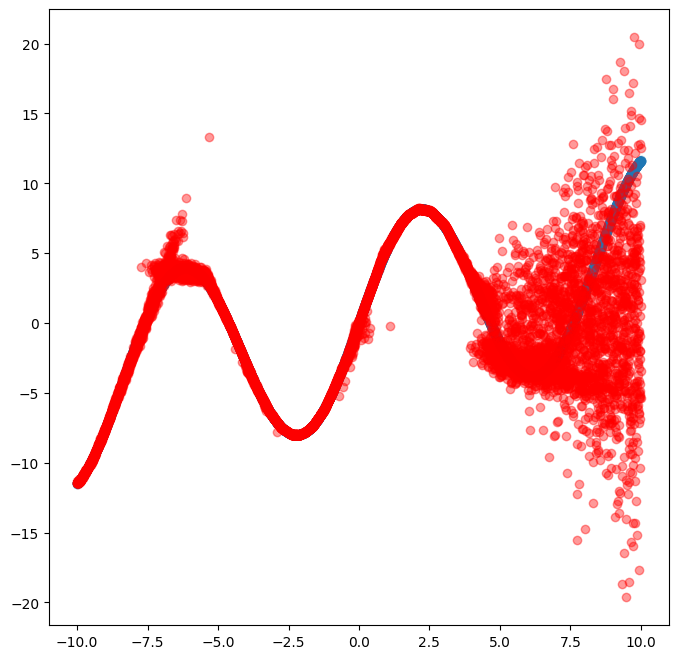

In [35]:
mix = Categorical(pi)
comp = torch.distributions.Normal(loc=mu, scale=sigma)
mdndist = MixtureSameFamily(mix, comp)

samples = mdndist.sample((1,))

plt.figure(figsize=(8, 8))
plt.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), alpha=0.4, label="Real values")
plt.scatter(x_train.cpu().numpy(), samples.cpu().numpy(), alpha=0.4, color='red', label="In-sample prediction")

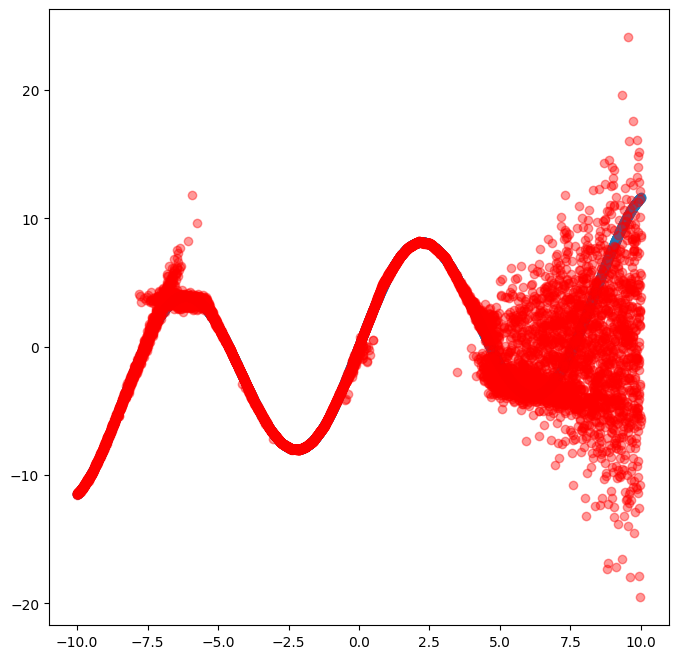

In [36]:
k = torch.multinomial(pi, 1).view(-1)
y_pred = torch.normal(mu, sigma)[np.arange(len(x_train)), k].data

plt.figure(figsize=(8, 8))
plt.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), alpha=0.4, label="Real values")
plt.scatter(x_train.cpu().numpy(), y_pred.cpu().numpy(), alpha=0.4, color='red', label="In-sample prediction")
plt.show()

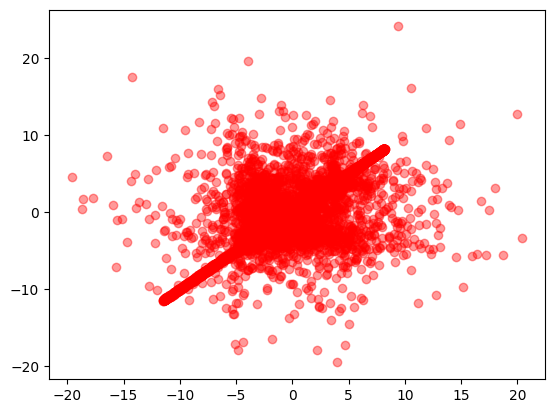

In [40]:
plt.scatter(samples.cpu().numpy(), y_pred.cpu().numpy(), alpha=0.4, color='red', label="In-sample prediction")


In [61]:
# Define the MDN
kanmdn = MultivariateKANMixtureDensityNetwork(input_dim=1, output_dim=1, hidden_dim=30, n_mixtures=3).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(params=kanmdn.parameters(), 
                             lr=0.001)

In [63]:
pi, mu, sigma = training_process(kanmdn, mdn_loss, optimizer, 3000, x_train, y_train)

Epoch: 0 | Loss: 5.57717
Epoch: 100 | Loss: 2.97562
Epoch: 200 | Loss: 2.82293
Epoch: 300 | Loss: 2.50913
Epoch: 400 | Loss: 1.60994
Epoch: 500 | Loss: 0.97621
Epoch: 600 | Loss: 0.84010
Epoch: 700 | Loss: 0.21223
Epoch: 800 | Loss: -0.31317
Epoch: 900 | Loss: 0.07873
Epoch: 1000 | Loss: 1.30960
Epoch: 1100 | Loss: 0.43744
Epoch: 1200 | Loss: -0.68540
Epoch: 1300 | Loss: -0.87701
Epoch: 1400 | Loss: -0.56741
Epoch: 1500 | Loss: 0.27936
Epoch: 1600 | Loss: -0.58551
Epoch: 1700 | Loss: 0.29278
Epoch: 1800 | Loss: -0.36449
Epoch: 1900 | Loss: -1.28831
Epoch: 2000 | Loss: -0.82577
Epoch: 2100 | Loss: -0.88184
Epoch: 2200 | Loss: -0.95496
Epoch: 2300 | Loss: -1.30205
Epoch: 2400 | Loss: -0.02978
Epoch: 2500 | Loss: -0.62796
Epoch: 2600 | Loss: -1.50034
Epoch: 2700 | Loss: -1.22215
Epoch: 2800 | Loss: -0.86948
Epoch: 2900 | Loss: -1.10480


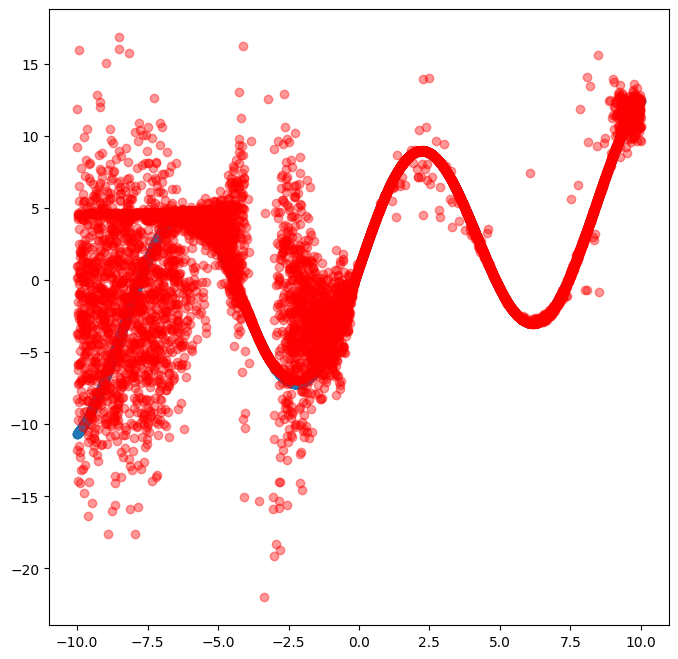

In [64]:
k = torch.multinomial(pi, 1).view(-1)
y_pred = torch.normal(mu, sigma)[np.arange(len(x_train)), k].data

plt.figure(figsize=(8, 8))
plt.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), alpha=0.4, label="Real values")
plt.scatter(x_train.cpu().numpy(), y_pred.cpu().numpy(), alpha=0.4, color='red', label="In-sample prediction")
plt.show()

In [37]:
# Define the MDN
chebykanmdn = ChebyKANMixtureDensityNetwork(input_dim=1, hidden_dim=30, n_mixtures=3, degree=4).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(params=chebykanmdn.parameters(), 
                             lr=0.001)

In [38]:
for epoch in range(2000):
    ### Training
    chebykanmdn.train()

    # 1. Forward pass
    pi, mu, sigma = chebykanmdn(x_train)
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = mdn_loss(y_train, mu, sigma, pi)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    chebykanmdn.eval()
    with torch.inference_mode():
      # 1. Forward pass
      pi, mu, sigma = chebykanmdn(x_train)
      
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}")

Epoch: 0 | Loss: 16.64688
Epoch: 100 | Loss: 3.09882
Epoch: 200 | Loss: 2.94430
Epoch: 300 | Loss: 2.54606
Epoch: 400 | Loss: 2.18191
Epoch: 500 | Loss: 2.50643
Epoch: 600 | Loss: 1.95694
Epoch: 700 | Loss: 1.71613
Epoch: 800 | Loss: 1.67378
Epoch: 900 | Loss: 1.79007
Epoch: 1000 | Loss: 1.75376
Epoch: 1100 | Loss: 1.47925
Epoch: 1200 | Loss: 1.60211
Epoch: 1300 | Loss: 1.42018
Epoch: 1400 | Loss: 1.50444
Epoch: 1500 | Loss: 1.25827
Epoch: 1600 | Loss: 1.50002
Epoch: 1700 | Loss: 1.18276
Epoch: 1800 | Loss: 1.97891
Epoch: 1900 | Loss: 1.51091


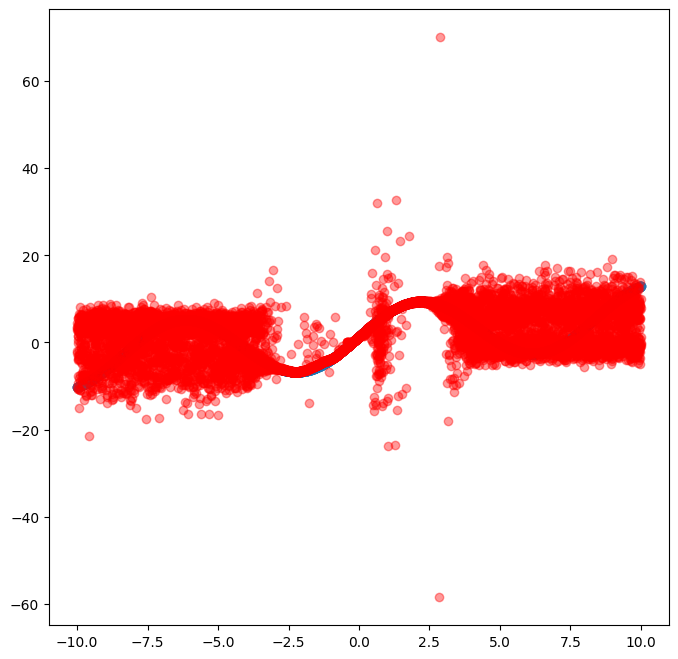

In [39]:
k = torch.multinomial(pi, 1).view(-1)
y_pred = torch.normal(mu, sigma)[np.arange(len(x_train)), k].data

plt.figure(figsize=(8, 8))
plt.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), alpha=0.4, label="Real values")
plt.scatter(x_train.cpu().numpy(), y_pred.cpu().numpy(), alpha=0.4, color='red', label="In-sample prediction")
plt.show()

In [87]:
# Define the MDN
fourierkanmdn = FourierKANMixtureDensityNetwork(input_dim=1, hidden_dim=30, n_mixtures=3, gridsize=1, smooth_init=True).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(params=fourierkanmdn.parameters(), 
                             lr=0.001)

In [88]:
for epoch in range(2000):
    ### Training
    fourierkanmdn.train()

    # 1. Forward pass
    pi, mu, sigma = fourierkanmdn(x_train)
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = mdn_loss(y_train, mu, sigma, pi)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    fourierkanmdn.eval()
    with torch.inference_mode():
      # 1. Forward pass
      pi, mu, sigma = fourierkanmdn(x_train)
      
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}")

Epoch: 0 | Loss: 3.29245
Epoch: 100 | Loss: 2.84567
Epoch: 200 | Loss: 2.68585
Epoch: 300 | Loss: 2.11417
Epoch: 400 | Loss: 2.06406
Epoch: 500 | Loss: 1.28863
Epoch: 600 | Loss: 1.46814
Epoch: 700 | Loss: 1.04017
Epoch: 800 | Loss: 0.76279
Epoch: 900 | Loss: 0.55927
Epoch: 1000 | Loss: 0.48300
Epoch: 1100 | Loss: 0.39552
Epoch: 1200 | Loss: 0.41930
Epoch: 1300 | Loss: 0.28324
Epoch: 1400 | Loss: 1.61886
Epoch: 1500 | Loss: 0.39476
Epoch: 1600 | Loss: 0.22755
Epoch: 1700 | Loss: 0.18787
Epoch: 1800 | Loss: 0.42807
Epoch: 1900 | Loss: 0.16055


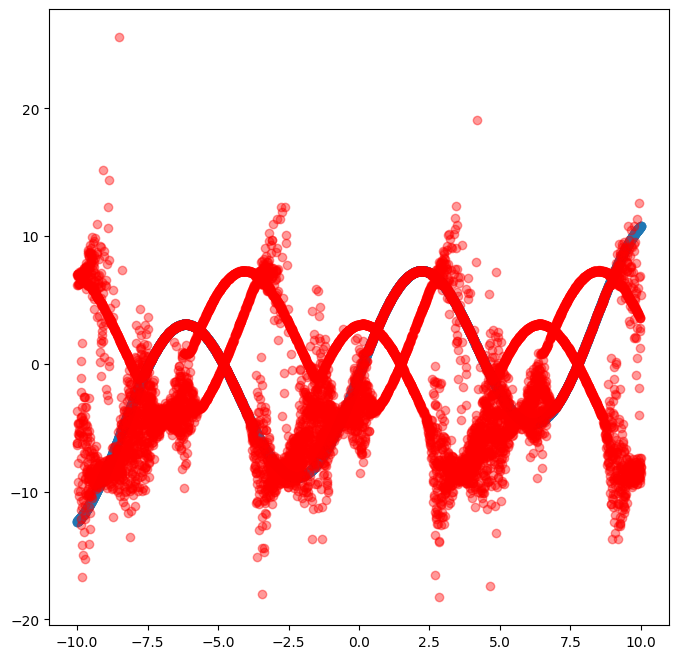

In [89]:
k = torch.multinomial(pi, 1).view(-1)
y_pred = torch.normal(mu, sigma)[np.arange(len(x_train)), k].data

plt.figure(figsize=(8, 8))
plt.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), alpha=0.4, label="Real values")
plt.scatter(x_train.cpu().numpy(), y_pred.cpu().numpy(), alpha=0.4, color='red', label="In-sample prediction")
plt.show()